In [2]:
using Polynomials, LinearAlgebra, Plots,DataFrames,CSV

## Zadanie 1 - porównanie metod faktoryzacji

In [9]:
ref = rand(1000)
A = rand(1000,1000)
b = A*ref
df = DataFrame(Method=String[],Difference=Float64[],Time=Float64[])

invMethod = ref - inv(A)*b
res1 = sqrt(dot(invMethod,invMethod))
time1 = @elapsed inv(A)*b
push!(df,("inv()",res1,time1))

normMethod = ref - A\b
res2 = sqrt(dot(normMethod,normMethod))
time2 = @elapsed A\b
push!(df,("/",res2,time2))

Af = factorize(A)
factMethod = ref - Af\b
res3 = sqrt(dot(factMethod,factMethod))
time3 = @elapsed factorize(A)\b
push!(df,("factorize()",res3,time3))

df

,Method,Difference,Time
,String,Float64,Float64
1,inv(),5.15775e-11,0.0396095
2,/,2.7284e-11,0.0129765
3,factorize(),2.7284e-11,0.0137973


## Zadanie 2 - faktoryzacja QR danych z poprzednich labów

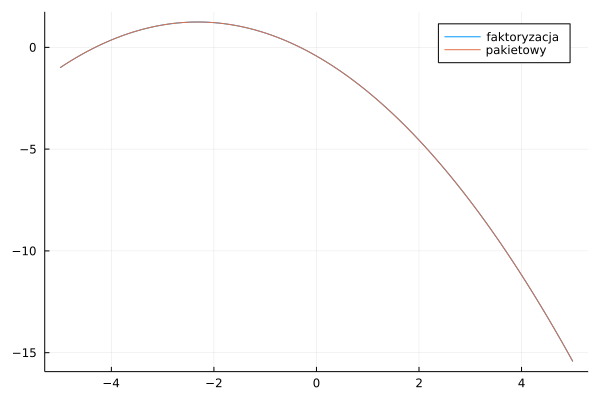

In [4]:
data = CSV.read("ecg_data.csv", DataFrame)
x = data.signalN
y = data.signalV
A=zeros(73,3) 
A[:,1]=x.^2
A[:,2]=x
A[:,3]=ones(73)
AF=factorize(A)
siema = AF.R\((Transpose(AF.Q)*y)[1:3])
wielomian = Polynomial(siema)
idealny = fit(x,y, 2)
xs = -5:5
plot(wielomian,extrema(xs)...,label="faktoryzacja")
plot!(idealny,extrema(xs)...,label="pakietowy")

## Zadanie 3 - zastosowanie faktoryzacji QR

Algorytm QR polega na wyliczaniu wartości własnych oraz wektorów własnych macierzy. Składa się z następujących kroków:
1. wykonanie faktoryzacji QR na macierzy
2. zapisanie macierzy jako iloczynu macierzy ortogonalnej oraz macierzy trójkątnej własnej
3. mnożenie czynników w odwrotnej kolejności

W algorytmie korzystamy z następującej zależności:

A<sub>k+1</sub> = R<sub>k</sub>Q<sub>k</sub> = Q<sup>-1</sup><sub>k</sub>Q<sub>k</sub>R<sub>k</sub>Q<sub>k</sub>=
Q<sup>-1</sup><sub>k</sub>A<sub>k</sub>Q<sub>k</sub> = Q<sup>T</sup><sub>k</sub>A<sub>k</sub>Q<sub>k</sub>

Końcowe równanie ilustruje podobieństwo wszystkich macierzy A<sub>k</sub>, z czego wiemy, że mają takie same wartości własne.

Warto pamiętać, że algorytm QR może zawieść, jeśli problem obliczania wartości własnych jest słabo uwarunkowany numerycznie.

In [11]:
function myEigenValues(A,howPrecise)
    for i in 1:howPrecise
        Af = qr(A)
        A = Transpose(Af.Q)*A*Af.Q
    end
    values = [A[i,i] for i in 1:size(A,1)]
end

myEigenValues (generic function with 1 method)

Powyżej zaimplementowany algorytm QR. Żeby sprawdzić, czy jakkolwiek jest użyteczny skorzystamy z twierdzenia Gerszgorina, które pozwoli nam określić ograniczenia na wartości własne macierzy. Możemy to sobie zwizualizować jako dyski w zespolonym układzie wspołrzędnym

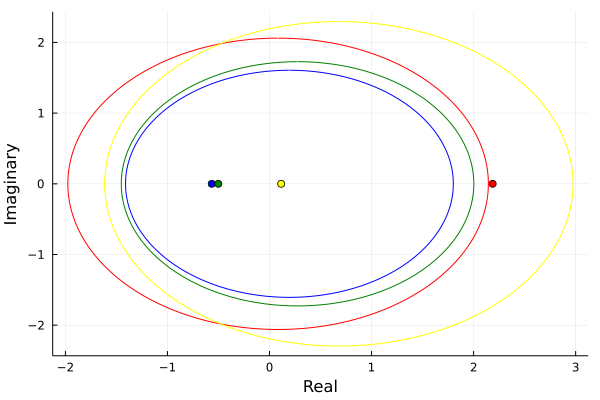

In [14]:
function get_disks(A)
    disks = []
    for i in 1:size(A,1)
        res = 0
        for j in 1:size(A,2)
            if j != i
               res += abs(A[i,j]) 
            end
        end
        push!(disks, (A[i,i],res)) 
    end
    disks
end

function draw_circle(h,k,r)
    theta = 0:0.01:2*pi
    h .+ r*sin.(theta), k.+ r*cos.(theta)
end

function make_complex(ev)
    [(e,0) for e in ev]
end
A = rand(4,4)
ev = myEigenValues(A,10)
ev_plot = make_complex(ev)
disks = get_disks(A)
colors = [:red, :blue, :green, :yellow]
a = scatter(
    xlabel = "Real", 
    ylabel = "Imaginary",
    )
for i in 1:size(disks,1)
    d = disks[i]
    scatter!(ev_plot[i],
        color = colors[i],
        fillalpha = 0.25,
        label = ""
    )
    plot!(draw_circle(d[1],0,d[2]), 
        color = colors[i], 
        fillalpha = 0.25, 
        label = ""
    )
end
a